# Disaster Tweet Classification - RidgeClassifierCV
## NLP with Disaster Tweets
------------------
### GOAL
- Predicting whether a given tweet is about a real disaster or not
- if so, predict a `1`. if not, predict a `0`


### Reference
- [competition main page](https://www.kaggle.com/c/nlp-getting-started)
- [example code](https://www.kaggle.com/datarohitingole/disaster-tweet-classification-ridgeclassifiercv)
- [comparing the performance of different Machine Learning Algorithm](https://dibyendudeb.com/comparing-machine-learning-algorithms/)

# 0. Importing Libraries

In [19]:
# for loading and preprocessing the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

# for training the model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree, linear_model, neighbors, naive_bayes, ensemble
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# for evaluating classification model
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Comparing all machine learning algorithms
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve

# 2. Data Preprocessing
## Contents
1. Dealing with Missing Values
2. Convert Text to Vectors using Count Vectorizer

## Data Description
--------------
### Files
- `train.csv` : the training set
- `test.csv` : the test set
- `sample_submission.csv` : a sample submission file in the correct format

### Columns
- `id` : a unique identifier for each tweet
- `text` : the text of the tweet
- `location` : the location the tweet was sent from 
- `keyword` : a particular keyword from th tweet
- `target` : in train.csv only, this denotes whether a tweet is about a real disaster(1) or not(0)

In [2]:
# loading the .csv form data
data_path = './data/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')

all_data = [train,test]

In [3]:
print('train_shape:', train.shape)
print('test_shape;', test.shape)

train_shape: (7613, 5)
test_shape; (3263, 4)


In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## 2-1. Dealing with Missing Values

In [6]:
for data in all_data:
    data.drop(["location", "id"], axis = 1, inplace = True)

In [7]:
# data prepocessing with regrex

def remove_URL(text): # remove url pattern in text
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text): # remove html pattern in text
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return html.sub(r'', text)
    #return re.sub(html, '', text)

def remove_punct(text): # remove punctuation in text: (;, ', ", :, ., , etc..)
  table = str.maketrans('', '', string.punctuation)
  return text.translate(table)

In [8]:
for data in all_data:
  data['text'] = data['text'].apply(lambda x: remove_URL(x))
  data['text'] = data['text'].apply(lambda x: remove_html(x))
  data['text'] = data['text'].apply(lambda x: remove_punct(x))

## 2-1. Convert Text to Vectors using Count Vectorizer

### What is the Count Vectorizer?
- convert a collection of text documents to a matrix of token counts

### How to Use
```python
# python example code
corpus = ["This is the first document", "This document is the second document", "And this is the thrid one"]
vectorize = CounterVectorize()
X = vectorize.fit_transform(corpus)
```
- vectorizer.get_feature_names_out()
> array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this'], ...)
- X.toarray()
> [[0 1 1 1 0 0 1 0 1]  
 [0 2 0 1 0 1 1 0 1]  
 [1 0 0 1 1 0 1 1 1]]


In [9]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(max_features=2000)

X = count_vectorizer.fit_transform(train["text"]).toarray()
test = count_vectorizer.transform(test["text"]).toarray()
y = train['target']

In [10]:
# split the data <train : test = 8 : 2>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# 3. Model
## Contents
1. Dealing with Missing Values
2. RidgeClassifierCV

## Model Description
--------------
### Ensemble
- Combine the predictions of several base estimators built with a given learning algorithm 
    - in order to improve generalizability / robustness over a single estimator.
- Boosting of Ensemble types

### Performance - f1-score


In [11]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    XGBClassifier(),
    CatBoostClassifier()  
    ]

In [12]:
row_index = 0
MLA_compare = pd.DataFrame()

for classifier in MLA:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    classifier_accuracy_score = accuracy_score(y_test, y_pred)


    MLA_name = classifier.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'Accuracy Score'] = classifier_accuracy_score*100

    print(MLA_name, "Done")
    row_index+=1

AdaBoostClassifier Done
BaggingClassifier Done
ExtraTreesClassifier Done
GradientBoostingClassifier Done
RandomForestClassifier Done
PassiveAggressiveClassifier Done
RidgeClassifierCV Done
SGDClassifier Done
Perceptron Done
BernoulliNB Done
GaussianNB Done
KNeighborsClassifier Done
DecisionTreeClassifier Done
ExtraTreeClassifier Done


/Users/mac/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:33:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier Done
Learning rate set to 0.022283
0:	learn: 0.6903304	total: 56.1ms	remaining: 56s
1:	learn: 0.6870982	total: 64.3ms	remaining: 32.1s
2:	learn: 0.6849708	total: 71.5ms	remaining: 23.8s
3:	learn: 0.6825957	total: 79.7ms	remaining: 19.8s
4:	learn: 0.6801002	total: 87ms	remaining: 17.3s
5:	learn: 0.6779782	total: 94.9ms	remaining: 15.7s
6:	learn: 0.6755461	total: 102ms	remaining: 14.5s
7:	learn: 0.6734505	total: 110ms	remaining: 13.6s
8:	learn: 0.6711925	total: 117ms	remaining: 12.9s
9:	learn: 0.6695775	total: 125ms	remaining: 12.4s
10:	learn: 0.6681076	total: 132ms	remaining: 11.9s
11:	learn: 0.6663797	total: 139ms	remaining: 11.5s
12:	learn: 0.6645189	total: 147ms	remaining: 11.2s
13:	learn: 0.6

163:	learn: 0.5620459	total: 1.38s	remaining: 7.05s
164:	learn: 0.5617955	total: 1.39s	remaining: 7.05s
165:	learn: 0.5615760	total: 1.4s	remaining: 7.04s
166:	learn: 0.5612824	total: 1.41s	remaining: 7.04s
167:	learn: 0.5610545	total: 1.42s	remaining: 7.03s
168:	learn: 0.5607437	total: 1.43s	remaining: 7.02s
169:	learn: 0.5603084	total: 1.44s	remaining: 7.01s
170:	learn: 0.5599545	total: 1.45s	remaining: 7.01s
171:	learn: 0.5595440	total: 1.45s	remaining: 7s
172:	learn: 0.5593027	total: 1.46s	remaining: 6.99s
173:	learn: 0.5589166	total: 1.47s	remaining: 6.99s
174:	learn: 0.5584885	total: 1.48s	remaining: 7s
175:	learn: 0.5580834	total: 1.49s	remaining: 6.99s
176:	learn: 0.5577275	total: 1.5s	remaining: 6.99s
177:	learn: 0.5572540	total: 1.51s	remaining: 6.98s
178:	learn: 0.5568599	total: 1.52s	remaining: 6.96s
179:	learn: 0.5564836	total: 1.53s	remaining: 6.95s
180:	learn: 0.5561678	total: 1.53s	remaining: 6.94s
181:	learn: 0.5557810	total: 1.54s	remaining: 6.93s
182:	learn: 0.555392

322:	learn: 0.5202672	total: 2.77s	remaining: 5.81s
323:	learn: 0.5200042	total: 2.78s	remaining: 5.8s
324:	learn: 0.5198099	total: 2.79s	remaining: 5.79s
325:	learn: 0.5195488	total: 2.8s	remaining: 5.78s
326:	learn: 0.5193746	total: 2.81s	remaining: 5.77s
327:	learn: 0.5190128	total: 2.81s	remaining: 5.76s
328:	learn: 0.5188282	total: 2.82s	remaining: 5.75s
329:	learn: 0.5186552	total: 2.83s	remaining: 5.74s
330:	learn: 0.5184973	total: 2.84s	remaining: 5.73s
331:	learn: 0.5182111	total: 2.85s	remaining: 5.72s
332:	learn: 0.5178927	total: 2.85s	remaining: 5.71s
333:	learn: 0.5176576	total: 2.86s	remaining: 5.7s
334:	learn: 0.5173839	total: 2.87s	remaining: 5.7s
335:	learn: 0.5171909	total: 2.88s	remaining: 5.69s
336:	learn: 0.5170134	total: 2.88s	remaining: 5.68s
337:	learn: 0.5168771	total: 2.89s	remaining: 5.67s
338:	learn: 0.5166571	total: 2.9s	remaining: 5.66s
339:	learn: 0.5164035	total: 2.91s	remaining: 5.65s
340:	learn: 0.5162244	total: 2.92s	remaining: 5.64s
341:	learn: 0.515

488:	learn: 0.4836919	total: 4.17s	remaining: 4.36s
489:	learn: 0.4835179	total: 4.18s	remaining: 4.35s
490:	learn: 0.4832715	total: 4.19s	remaining: 4.34s
491:	learn: 0.4830630	total: 4.2s	remaining: 4.33s
492:	learn: 0.4828665	total: 4.2s	remaining: 4.32s
493:	learn: 0.4826587	total: 4.21s	remaining: 4.31s
494:	learn: 0.4823925	total: 4.22s	remaining: 4.3s
495:	learn: 0.4821442	total: 4.23s	remaining: 4.3s
496:	learn: 0.4819412	total: 4.24s	remaining: 4.29s
497:	learn: 0.4816605	total: 4.25s	remaining: 4.28s
498:	learn: 0.4814473	total: 4.25s	remaining: 4.27s
499:	learn: 0.4812616	total: 4.26s	remaining: 4.26s
500:	learn: 0.4810898	total: 4.27s	remaining: 4.25s
501:	learn: 0.4808304	total: 4.28s	remaining: 4.25s
502:	learn: 0.4805698	total: 4.29s	remaining: 4.24s
503:	learn: 0.4803518	total: 4.3s	remaining: 4.23s
504:	learn: 0.4800981	total: 4.3s	remaining: 4.22s
505:	learn: 0.4799051	total: 4.31s	remaining: 4.21s
506:	learn: 0.4797232	total: 4.32s	remaining: 4.2s
507:	learn: 0.47948

661:	learn: 0.4506596	total: 5.56s	remaining: 2.84s
662:	learn: 0.4504917	total: 5.57s	remaining: 2.83s
663:	learn: 0.4503189	total: 5.58s	remaining: 2.82s
664:	learn: 0.4502124	total: 5.59s	remaining: 2.81s
665:	learn: 0.4500558	total: 5.6s	remaining: 2.81s
666:	learn: 0.4498500	total: 5.61s	remaining: 2.8s
667:	learn: 0.4496876	total: 5.61s	remaining: 2.79s
668:	learn: 0.4495269	total: 5.62s	remaining: 2.78s
669:	learn: 0.4493326	total: 5.63s	remaining: 2.77s
670:	learn: 0.4491972	total: 5.64s	remaining: 2.77s
671:	learn: 0.4490440	total: 5.65s	remaining: 2.76s
672:	learn: 0.4488355	total: 5.66s	remaining: 2.75s
673:	learn: 0.4485903	total: 5.66s	remaining: 2.74s
674:	learn: 0.4484369	total: 5.67s	remaining: 2.73s
675:	learn: 0.4482191	total: 5.68s	remaining: 2.72s
676:	learn: 0.4480580	total: 5.69s	remaining: 2.71s
677:	learn: 0.4479183	total: 5.7s	remaining: 2.71s
678:	learn: 0.4477544	total: 5.7s	remaining: 2.7s
679:	learn: 0.4476295	total: 5.71s	remaining: 2.69s
680:	learn: 0.447

837:	learn: 0.4241275	total: 6.97s	remaining: 1.35s
838:	learn: 0.4240361	total: 6.97s	remaining: 1.34s
839:	learn: 0.4239166	total: 6.98s	remaining: 1.33s
840:	learn: 0.4237620	total: 6.99s	remaining: 1.32s
841:	learn: 0.4236695	total: 7s	remaining: 1.31s
842:	learn: 0.4235436	total: 7s	remaining: 1.3s
843:	learn: 0.4233916	total: 7.01s	remaining: 1.3s
844:	learn: 0.4232447	total: 7.02s	remaining: 1.29s
845:	learn: 0.4231390	total: 7.03s	remaining: 1.28s
846:	learn: 0.4230201	total: 7.04s	remaining: 1.27s
847:	learn: 0.4229248	total: 7.04s	remaining: 1.26s
848:	learn: 0.4227496	total: 7.05s	remaining: 1.25s
849:	learn: 0.4226638	total: 7.06s	remaining: 1.25s
850:	learn: 0.4224884	total: 7.07s	remaining: 1.24s
851:	learn: 0.4223558	total: 7.07s	remaining: 1.23s
852:	learn: 0.4222310	total: 7.08s	remaining: 1.22s
853:	learn: 0.4220450	total: 7.09s	remaining: 1.21s
854:	learn: 0.4218857	total: 7.1s	remaining: 1.2s
855:	learn: 0.4217195	total: 7.11s	remaining: 1.2s
856:	learn: 0.4215843	t

CatBoostClassifier Done


In [13]:
MLA_compare = MLA_compare.sort_values(by="Accuracy Score", ascending=False).reset_index(drop=True)
MLA_compare

,MLA Name,Accuracy Score
0,RidgeClassifierCV,79.645437
1,BernoulliNB,79.645437
2,RandomForestClassifier,79.448457
3,ExtraTreesClassifier,78.988838
4,SGDClassifier,78.791858
5,XGBClassifier,78.791858
6,CatBoostClassifier,78.660538
7,GaussianNB,76.690742
8,BaggingClassifier,76.231123
9,PassiveAggressiveClassifier,76.099803


# Comapring all MLA
- precision
- recall
- accuracy
- f1-score

In [31]:
2/3

0.6666666666666666

In [33]:
# Comparing all machine learning algorithms
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve

row_index = 0
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

for alg in MLA:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)

    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA used'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 4)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 4)
    
    
    recall = recall_score(y_test, predicted)
    precision = precision_score(y_test, predicted)
    MLA_compare.loc[row_index, 'Precission'] = precision
    MLA_compare.loc[row_index, 'Recall'] = recall
    MLA_compare.loc[row_index, 'F1-score'] = round((2*precision*recall)/(precision+recall),4)
    MLA_compare.loc[row_index, 'AUC'] = auc(fp, tp)

    row_index+=1

/Users/mac/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.022283
0:	learn: 0.6903304	total: 6.63ms	remaining: 6.63s
1:	learn: 0.6870982	total: 14.1ms	remaining: 7.04s
2:	learn: 0.6849708	total: 21.5ms	remaining: 7.13s
3:	learn: 0.6825957	total: 29ms	remaining: 7.21s
4:	learn: 0.6801002	total: 36.9ms	remaining: 7.35s
5:	learn: 0.6779782	total: 44.5ms	remaining: 7.37s
6:	learn: 0.6755461	total: 52ms	remaining: 7.38s
7:	learn: 0.6734505	total: 59.5ms	remaining: 7.37s
8:	learn: 0.6711925	total: 66.9ms	remaining: 7.36s
9:	learn: 0.6695775	total: 74.2ms	remaining: 7.34s
10:	learn: 0.6681076	total: 81.9ms	remaining: 7.37s
11:	learn: 0.6663797	total: 89.8ms	remaining: 7.39s
12:	learn: 0.6645189	total: 97.2ms	remaining: 7.38s
13:	learn: 0.6625597	total

173:	learn: 0.5589166	total: 1.39s	remaining: 6.59s
174:	learn: 0.5584885	total: 1.4s	remaining: 6.59s
175:	learn: 0.5580834	total: 1.41s	remaining: 6.59s
176:	learn: 0.5577275	total: 1.42s	remaining: 6.58s
177:	learn: 0.5572540	total: 1.42s	remaining: 6.57s
178:	learn: 0.5568599	total: 1.43s	remaining: 6.56s
179:	learn: 0.5564836	total: 1.44s	remaining: 6.55s
180:	learn: 0.5561678	total: 1.45s	remaining: 6.54s
181:	learn: 0.5557810	total: 1.45s	remaining: 6.54s
182:	learn: 0.5553921	total: 1.46s	remaining: 6.53s
183:	learn: 0.5550606	total: 1.47s	remaining: 6.52s
184:	learn: 0.5548611	total: 1.48s	remaining: 6.51s
185:	learn: 0.5545308	total: 1.49s	remaining: 6.5s
186:	learn: 0.5542757	total: 1.49s	remaining: 6.49s
187:	learn: 0.5539680	total: 1.5s	remaining: 6.49s
188:	learn: 0.5535400	total: 1.51s	remaining: 6.48s
189:	learn: 0.5531848	total: 1.52s	remaining: 6.47s
190:	learn: 0.5528859	total: 1.52s	remaining: 6.46s
191:	learn: 0.5525378	total: 1.53s	remaining: 6.45s
192:	learn: 0.5

352:	learn: 0.5138862	total: 2.77s	remaining: 5.08s
353:	learn: 0.5136746	total: 2.78s	remaining: 5.08s
354:	learn: 0.5134407	total: 2.79s	remaining: 5.07s
355:	learn: 0.5132453	total: 2.8s	remaining: 5.06s
356:	learn: 0.5131157	total: 2.8s	remaining: 5.05s
357:	learn: 0.5129108	total: 2.81s	remaining: 5.04s
358:	learn: 0.5127193	total: 2.82s	remaining: 5.03s
359:	learn: 0.5124849	total: 2.83s	remaining: 5.03s
360:	learn: 0.5122672	total: 2.83s	remaining: 5.02s
361:	learn: 0.5120207	total: 2.84s	remaining: 5.01s
362:	learn: 0.5118060	total: 2.85s	remaining: 5s
363:	learn: 0.5116195	total: 2.86s	remaining: 4.99s
364:	learn: 0.5114100	total: 2.86s	remaining: 4.98s
365:	learn: 0.5111058	total: 2.87s	remaining: 4.97s
366:	learn: 0.5109220	total: 2.88s	remaining: 4.97s
367:	learn: 0.5107186	total: 2.89s	remaining: 4.96s
368:	learn: 0.5104868	total: 2.9s	remaining: 4.95s
369:	learn: 0.5102966	total: 2.9s	remaining: 4.94s
370:	learn: 0.5100983	total: 2.91s	remaining: 4.93s
371:	learn: 0.50988

534:	learn: 0.4736885	total: 4.15s	remaining: 3.61s
535:	learn: 0.4735299	total: 4.16s	remaining: 3.6s
536:	learn: 0.4733006	total: 4.17s	remaining: 3.59s
537:	learn: 0.4731504	total: 4.17s	remaining: 3.58s
538:	learn: 0.4729475	total: 4.18s	remaining: 3.58s
539:	learn: 0.4727262	total: 4.19s	remaining: 3.57s
540:	learn: 0.4725800	total: 4.2s	remaining: 3.56s
541:	learn: 0.4723690	total: 4.21s	remaining: 3.55s
542:	learn: 0.4721795	total: 4.21s	remaining: 3.54s
543:	learn: 0.4720183	total: 4.22s	remaining: 3.54s
544:	learn: 0.4718232	total: 4.23s	remaining: 3.53s
545:	learn: 0.4715883	total: 4.24s	remaining: 3.52s
546:	learn: 0.4714087	total: 4.24s	remaining: 3.51s
547:	learn: 0.4712395	total: 4.25s	remaining: 3.5s
548:	learn: 0.4710595	total: 4.26s	remaining: 3.5s
549:	learn: 0.4708547	total: 4.26s	remaining: 3.49s
550:	learn: 0.4706181	total: 4.27s	remaining: 3.48s
551:	learn: 0.4704069	total: 4.28s	remaining: 3.47s
552:	learn: 0.4702274	total: 4.29s	remaining: 3.47s
553:	learn: 0.47

694:	learn: 0.4453126	total: 5.54s	remaining: 2.43s
695:	learn: 0.4451229	total: 5.54s	remaining: 2.42s
696:	learn: 0.4449422	total: 5.55s	remaining: 2.41s
697:	learn: 0.4447893	total: 5.56s	remaining: 2.41s
698:	learn: 0.4446593	total: 5.57s	remaining: 2.4s
699:	learn: 0.4444686	total: 5.58s	remaining: 2.39s
700:	learn: 0.4443042	total: 5.59s	remaining: 2.38s
701:	learn: 0.4441406	total: 5.6s	remaining: 2.38s
702:	learn: 0.4439837	total: 5.61s	remaining: 2.37s
703:	learn: 0.4438049	total: 5.62s	remaining: 2.36s
704:	learn: 0.4436501	total: 5.62s	remaining: 2.35s
705:	learn: 0.4434917	total: 5.63s	remaining: 2.35s
706:	learn: 0.4433176	total: 5.64s	remaining: 2.34s
707:	learn: 0.4431577	total: 5.65s	remaining: 2.33s
708:	learn: 0.4430259	total: 5.66s	remaining: 2.32s
709:	learn: 0.4429375	total: 5.67s	remaining: 2.31s
710:	learn: 0.4427737	total: 5.68s	remaining: 2.31s
711:	learn: 0.4426066	total: 5.68s	remaining: 2.3s
712:	learn: 0.4424643	total: 5.69s	remaining: 2.29s
713:	learn: 0.4

865:	learn: 0.4205552	total: 6.93s	remaining: 1.07s
866:	learn: 0.4204796	total: 6.93s	remaining: 1.06s
867:	learn: 0.4203581	total: 6.94s	remaining: 1.05s
868:	learn: 0.4202502	total: 6.95s	remaining: 1.05s
869:	learn: 0.4201083	total: 6.96s	remaining: 1.04s
870:	learn: 0.4199889	total: 6.96s	remaining: 1.03s
871:	learn: 0.4199323	total: 6.97s	remaining: 1.02s
872:	learn: 0.4197976	total: 6.98s	remaining: 1.01s
873:	learn: 0.4196307	total: 6.99s	remaining: 1.01s
874:	learn: 0.4195434	total: 7s	remaining: 1000ms
875:	learn: 0.4194270	total: 7s	remaining: 991ms
876:	learn: 0.4193380	total: 7.01s	remaining: 983ms
877:	learn: 0.4192218	total: 7.02s	remaining: 976ms
878:	learn: 0.4191130	total: 7.03s	remaining: 968ms
879:	learn: 0.4189953	total: 7.04s	remaining: 959ms
880:	learn: 0.4188275	total: 7.04s	remaining: 951ms
881:	learn: 0.4186957	total: 7.05s	remaining: 943ms
882:	learn: 0.4185802	total: 7.06s	remaining: 935ms
883:	learn: 0.4184663	total: 7.07s	remaining: 927ms
884:	learn: 0.418

In [34]:
# f1-score 기준 정렬
MLA_compare.sort_values(by = ['F1-score'], ascending = False, inplace = True)    
MLA_compare

,MLA used,Train Accuracy,Test Accuracy,Precission,Recall,F1-score,AUC
6,RidgeClassifierCV,0.8711,0.7965,0.813820,0.665620,0.7323,0.778070
7,SGDClassifier,0.9108,0.7853,0.765411,0.701727,0.7322,0.773550
9,BernoulliNB,0.8340,0.7965,0.815029,0.664050,0.7318,0.777849
4,RandomForestClassifier,0.9833,0.7991,0.832998,0.649922,0.7302,0.778121
2,ExtraTreesClassifier,0.9833,0.7859,0.781193,0.678179,0.7261,0.770805
5,PassiveAggressiveClassifier,0.8806,0.7603,0.711180,0.718995,0.7151,0.754532
14,XGBClassifier,0.8525,0.7879,0.825726,0.624804,0.7113,0.764998
15,CatBoostClassifier,0.8580,0.7866,0.834764,0.610675,0.7053,0.761884
8,Perceptron,0.8765,0.7360,0.669553,0.728414,0.6977,0.734975
1,BaggingClassifier,0.9654,0.7617,0.745520,0.653061,0.6962,0.746395


Text(0.5, 0, 'Algorithm Name')

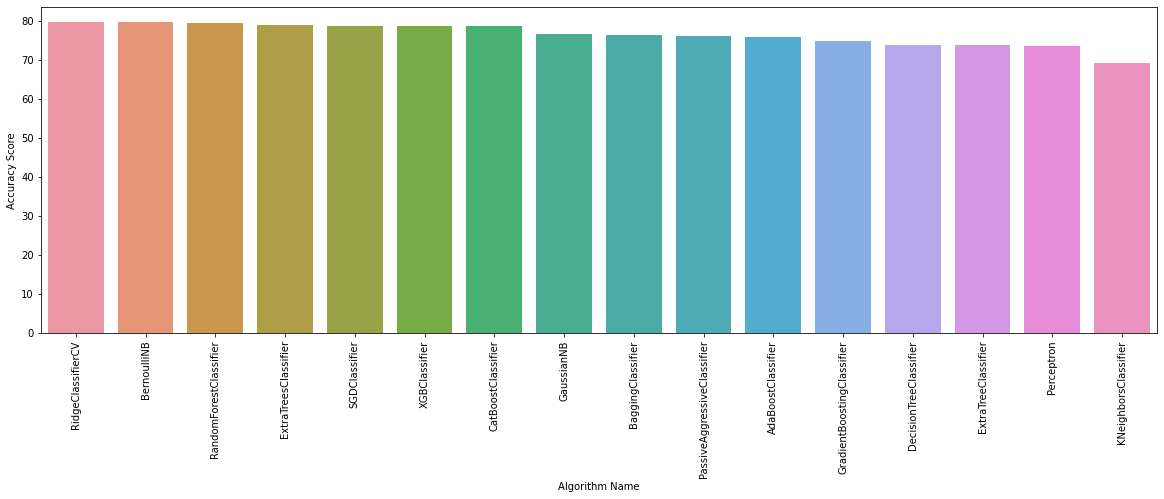

In [14]:
plt.rcParams["figure.figsize"] = (20,6)
sns.barplot(x="MLA Name", y="Accuracy Score", data = MLA_compare)
plt.xticks(rotation=90)
plt.xlabel("Algorithm Name")

In [15]:
classifier = linear_model.RidgeClassifierCV(cv=15)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Accuracy Score : ", accuracy_score(y_test, y_pred), "\n\n")
print(confusion_matrix(y_test, y_pred))

Accuracy Score :  0.7964543663821405 


[[789  97]
 [213 424]]


In [16]:
sample_submission = pd.read_csv(data_path + "sample_submission.csv")
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [17]:
test_pred = classifier.predict(test)

In [18]:
output = pd.DataFrame({'id': sample_submission.id, 'target': test_pred})
output.to_csv(data_path+'submission.csv', index=False)